In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import muon as mu

import warnings
warnings.filterwarnings('ignore')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

In [3]:
import liana as li

In [4]:
## load slide
slide = "C1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"../data/sma/{exp}/{exp}_{slide}/output_data"

In [5]:
mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
rna = mdata.mod["rna"]
msi = mdata.mod["msi"]

Metalinks

In [6]:
from applications._estimate_metalinks import estimate_metalinks

In [7]:
# Load metabolite receptor interactions
resource =  pd.read_csv('applications/data/MR_brain_20230808.csv')
# resource = dc.translate_net(resource, columns=['receptor'])
resource['receptor'] = resource['receptor'].str.title()
resource.head()

,Unnamed: 0,ligand,receptor
0,1,HMDB0000112,Gabrb2
1,3,HMDB0000216,Adra2B
2,4,HMDB0000068,Adra2B
3,20,HMDB0000148,Grm8
4,49,HMDB0000112,Gabra5


In [8]:
met_net = pd.read_csv("applications/data/PD_processed.csv")

In [9]:
# met_net = dc.translate_net(met_net, columns=['Symbol'])
met_net['Symbol'] = met_net['Symbol'].str.title()
met_net.head()

,Unnamed: 0,HMDB,Symbol,Direction,MetName,Transport,T_direction,Reversibility,DB,Type
0,18524,HMDB0059655,Phgdh,1,2-Hydroxyglutarate,unknown,unknown,irreversible,ReconProductionDegradation,met_est
1,21107,HMDB0006242,Aldh3A1,-1,"3,4-Dihydroxymandelaldehyde",unknown,unknown,irreversible,ReconProductionDegradation,met_est
2,21117,HMDB0000042,Aldh3A1,1,Acetic acid,unknown,unknown,irreversible,ReconProductionDegradation,met_est
3,21116,HMDB0001487,Aldh3A1,1,NADH,unknown,unknown,irreversible,ReconProductionDegradation,met_est
4,21115,HMDB0000663,Aldh3A1,1,Glucaric acid,unknown,unknown,irreversible,ReconProductionDegradation,met_est


In [10]:
# estimate metabolites
metalinks = estimate_metalinks(rna, resource=resource, met_net=met_net, consider_transport=True, min_n=3)

In [11]:
metalinks

MuData object with n_obs × n_vars = 2867 × 99
  uns:	'lesion_colors', 'log1p', 'region_colors', 'spatial'
  obsm:	'spatial', 'ulm_estimate', 'ulm_pvals', 'wmean_estimate', 'mmat'
  2 modalities
    metabolite:	2867 x 13
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      uns:	'lesion_colors', 'log1p', 'region_colors', 'spatial'
      obsm:	'spatial', 'ulm_estimate', 'ulm_pvals', 'wmean_estimate', 'mmat'
    rna:	2867 x 86
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells'
      uns:	'lesion_colors', 'log1p', 'region_colors', 'spatial'
      obsm:	'spatial', 'ulm_estimate', 'ulm_pvals', 'wmean_estimate', 'mmat'
      layers:	'counts'

HVG

In [12]:
sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=500)
rna = rna[:, rna.var['highly_variable']]

In [13]:
sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=50)

In [14]:
msi.var

,mean,std,mz,max_intensity,mz_raw,annotated,highly_variable,means,dispersions,dispersions_norm
name,,,,,,,,,,
156.26059,0.054031,0.209327,156.26,9.248456e+06,156.26059,NaN,False,0.000015,0.000156,-1.697950
156.26195,0.053002,0.216041,156.26,9.709658e+06,156.26195,NaN,False,0.000015,0.000196,-1.041784
156.48344,0.043413,0.192435,156.48,7.791353e+06,156.48344,NaN,False,0.000012,0.000188,-1.560041
156.4838,0.044560,0.197815,156.48,8.191085e+06,156.4838,NaN,False,0.000013,0.000216,-0.966551
156.485,0.047777,0.199507,156.49,8.323181e+06,156.485,NaN,False,0.000013,0.000171,-1.732839
...,...,...,...,...,...,...,...,...,...,...
1046.36442,0.039963,0.231604,1046.36,9.796245e+06,1046.36442,NaN,True,0.000015,0.000429,4.708579
1048.32025,0.043342,0.237810,1048.32,1.037273e+07,1048.32025,NaN,False,0.000016,0.000412,2.443542
1048.3319,0.053136,0.273897,1048.33,1.381839e+07,1048.3319,NaN,True,0.000022,0.000517,4.230426


In [15]:
msk = (msi.var.index.isin(msi.var['annotated']) + msi.var['highly_variable'])

In [16]:
msi = msi[:, msk].copy()

Test

In [17]:
# get reference coordinates
reference = mdata.mod["rna"].obsm["spatial"]


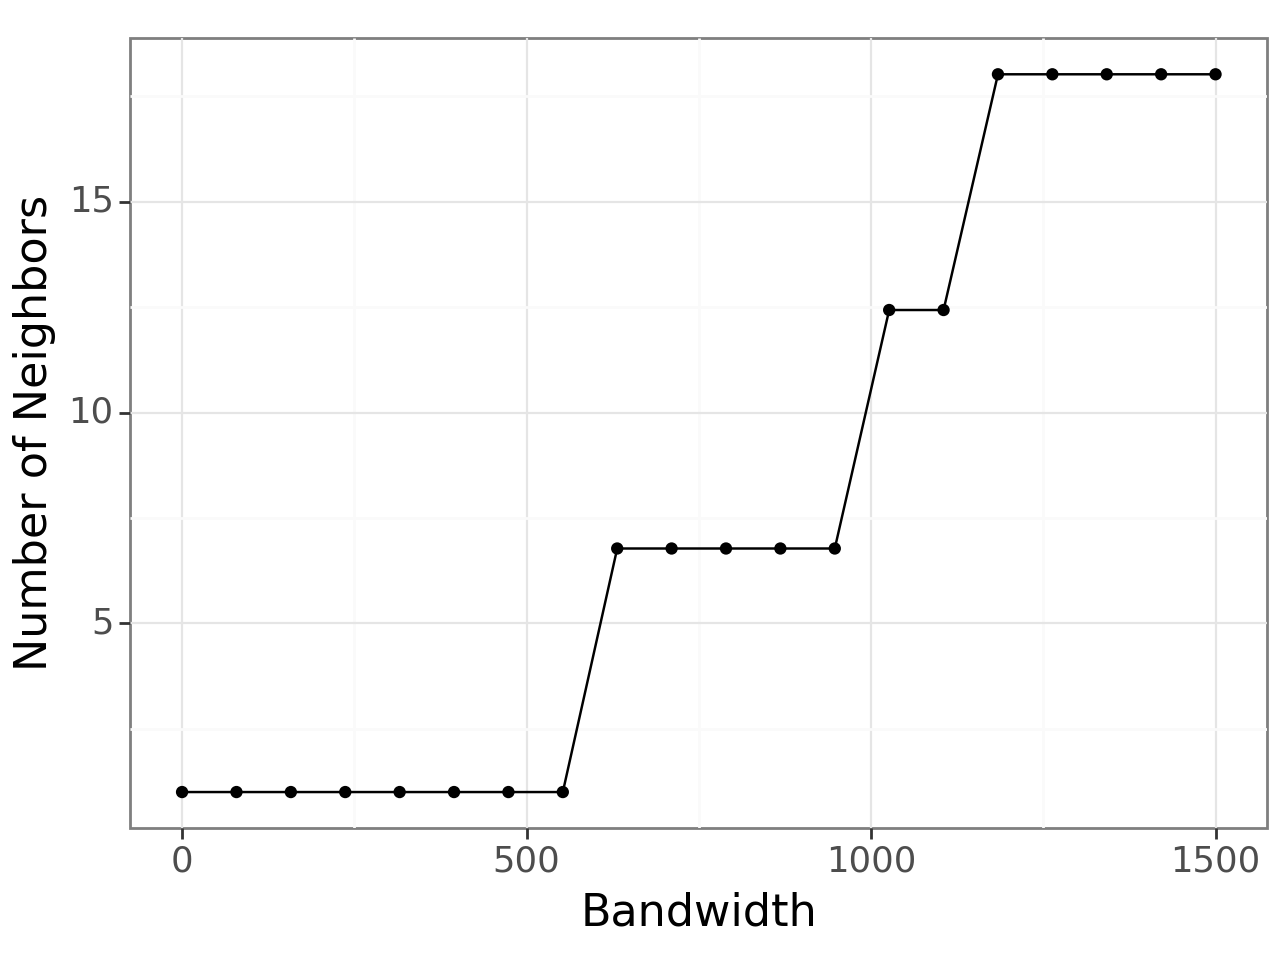

<Figure Size: (640 x 480)>

In [18]:
plot, _ = li.ut.query_bandwidth(coordinates=rna.obsm['spatial'], start=0, end=1500, interval_n=20, reference=reference)
plot

In [19]:
# distances of metabolties to RNA
li.ut.spatial_neighbors(msi, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [20]:
# get reference coordinates
reference = mdata.mod["msi"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [21]:
metalinks.mod['metabolite'].obsm = rna.obsm.copy()
metalinks.mod['metabolite'].obsp = rna.obsp.copy()

Mitsy

In [22]:
mdata.update_obs()

In [23]:
misty = li.mt.MistyData({"intra": msi, "rna":rna, "meta":metalinks.mod['metabolite']}, enforce_obs=False, obs=mdata.obs)


view intra is not a csr_matrix. Converting to csr_matrix
view meta is not a csr_matrix. Converting to csr_matrix


In [24]:
misty(model="linear", verbose=True, bypass_intra=True)

Now learning: 1048.38431: 100%|██████████| 56/56 [03:49<00:00,  4.11s/it]       


In [34]:
misty.uns['target_metrics'].sort_values("gain_R2", ascending=False).head(10)

,target,intra_R2,multi_R2,gain_R2,rna,meta
24,674.28833,0,0.815084,0.815084,0.937100,0.062900
1,390.16864,0,0.787561,0.787561,0.930056,0.069944
12,3-MT,0,0.774092,0.774092,0.904231,0.095769
23,674.28592,0,0.748825,0.748825,0.926116,0.073884
25,675.29202,0,0.648222,0.648222,0.899926,0.100074
11,431.08294,0,0.607957,0.607957,0.896221,0.103779
22,Dopamine (double),0,0.562021,0.562021,0.841875,0.158125
15,555.20345,0,0.401610,0.401610,0.817257,0.182743
16,555.20713,0,0.392160,0.392160,0.813318,0.186682
17,569.20536,0,0.387979,0.387979,0.799825,0.200175


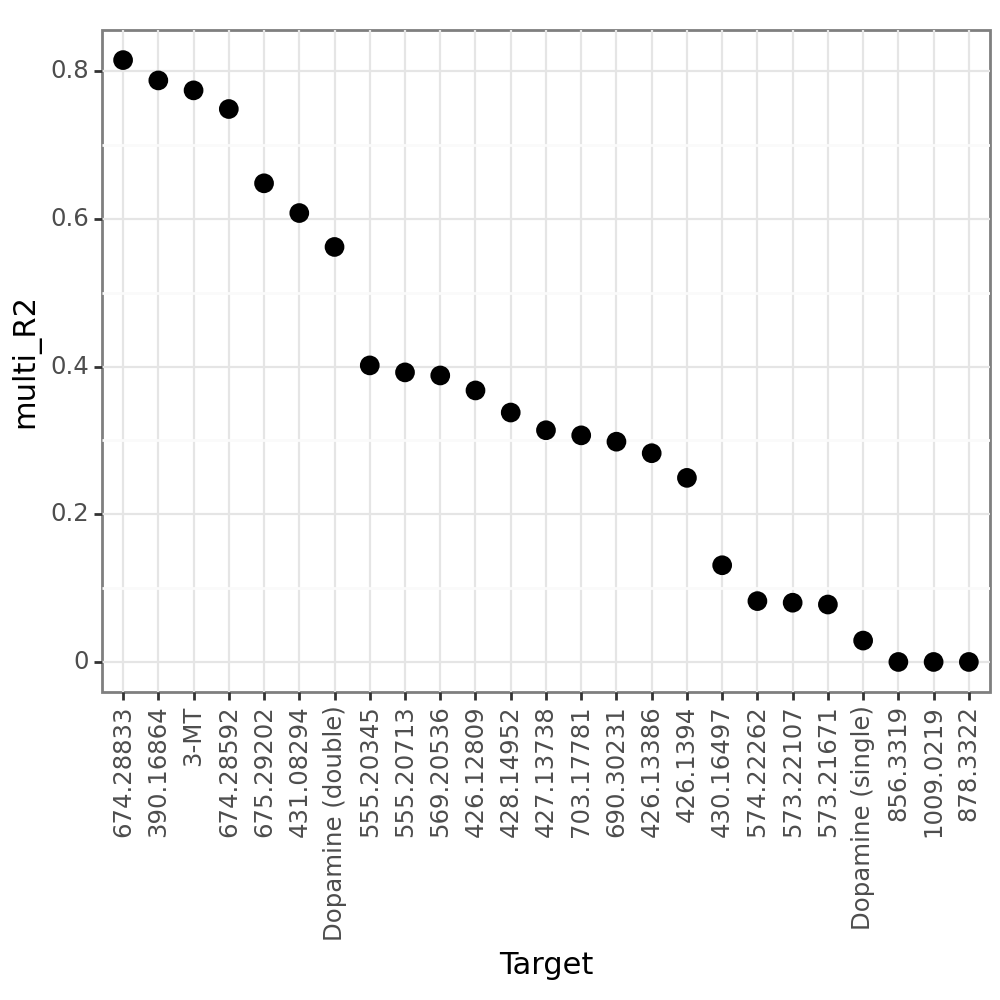

<Figure Size: (500 x 500)>

In [35]:
li.pl.target_metrics(misty, stat='multi_R2', top_n=25, return_fig=True)

In [36]:
import plotnine as p9

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


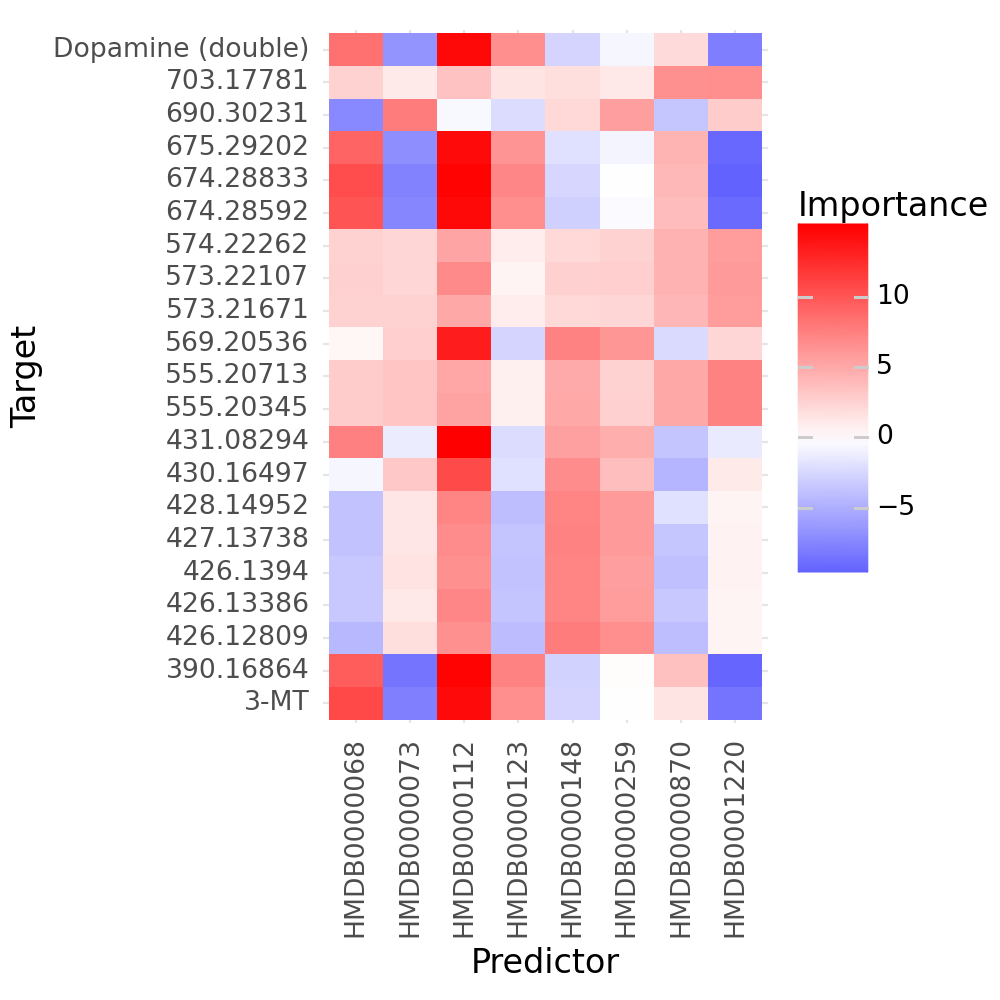

<Figure Size: (500 x 500)>

In [37]:
(
li.pl.interactions(misty, view='meta', top_n=50) +
p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)
)

In [38]:
sq.pl.spatial_scatter(msi, color=['Dopamine (double)', 'GABA'])

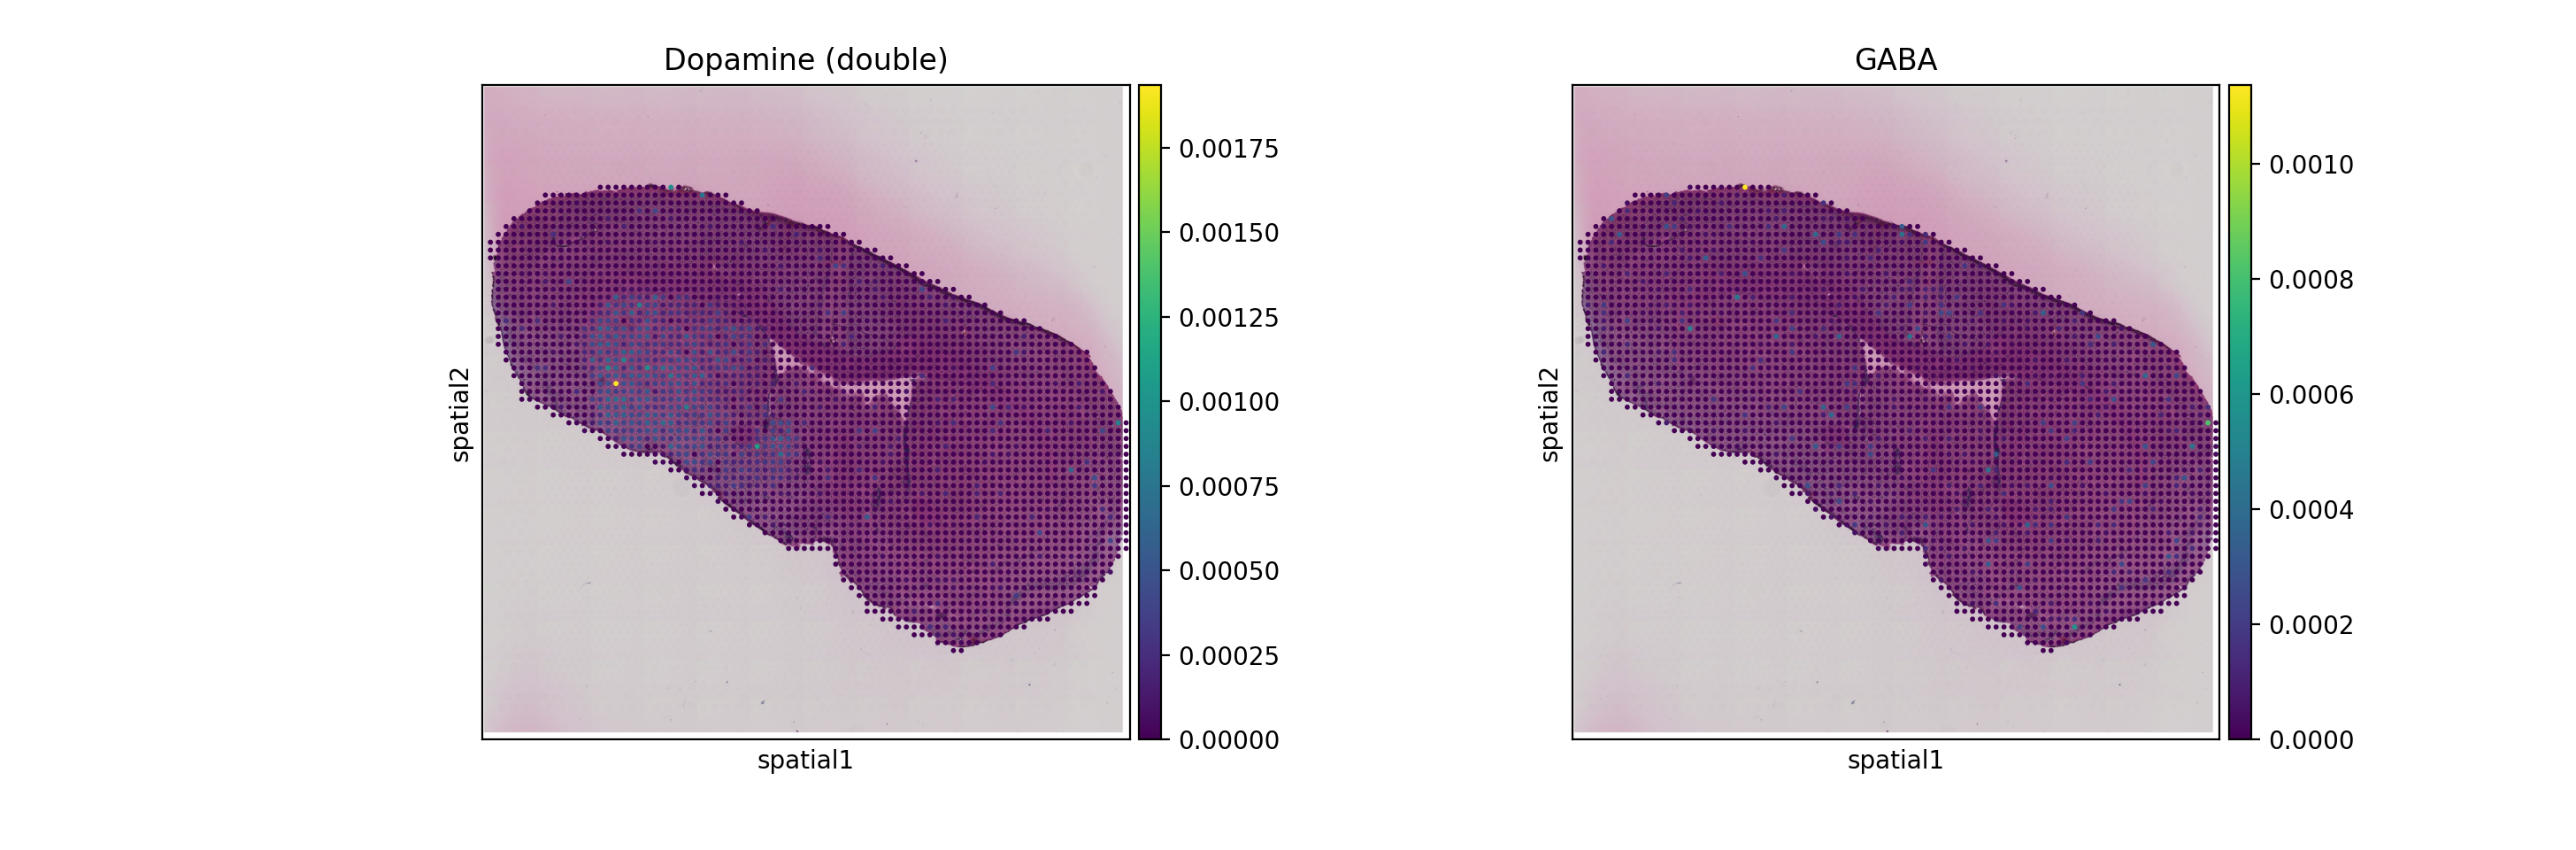

In [39]:
plt.show()

In [40]:
sq.pl.spatial_scatter(metalinks.mod['metabolite'], color=['HMDB0000073', 'HMDB0000112'])

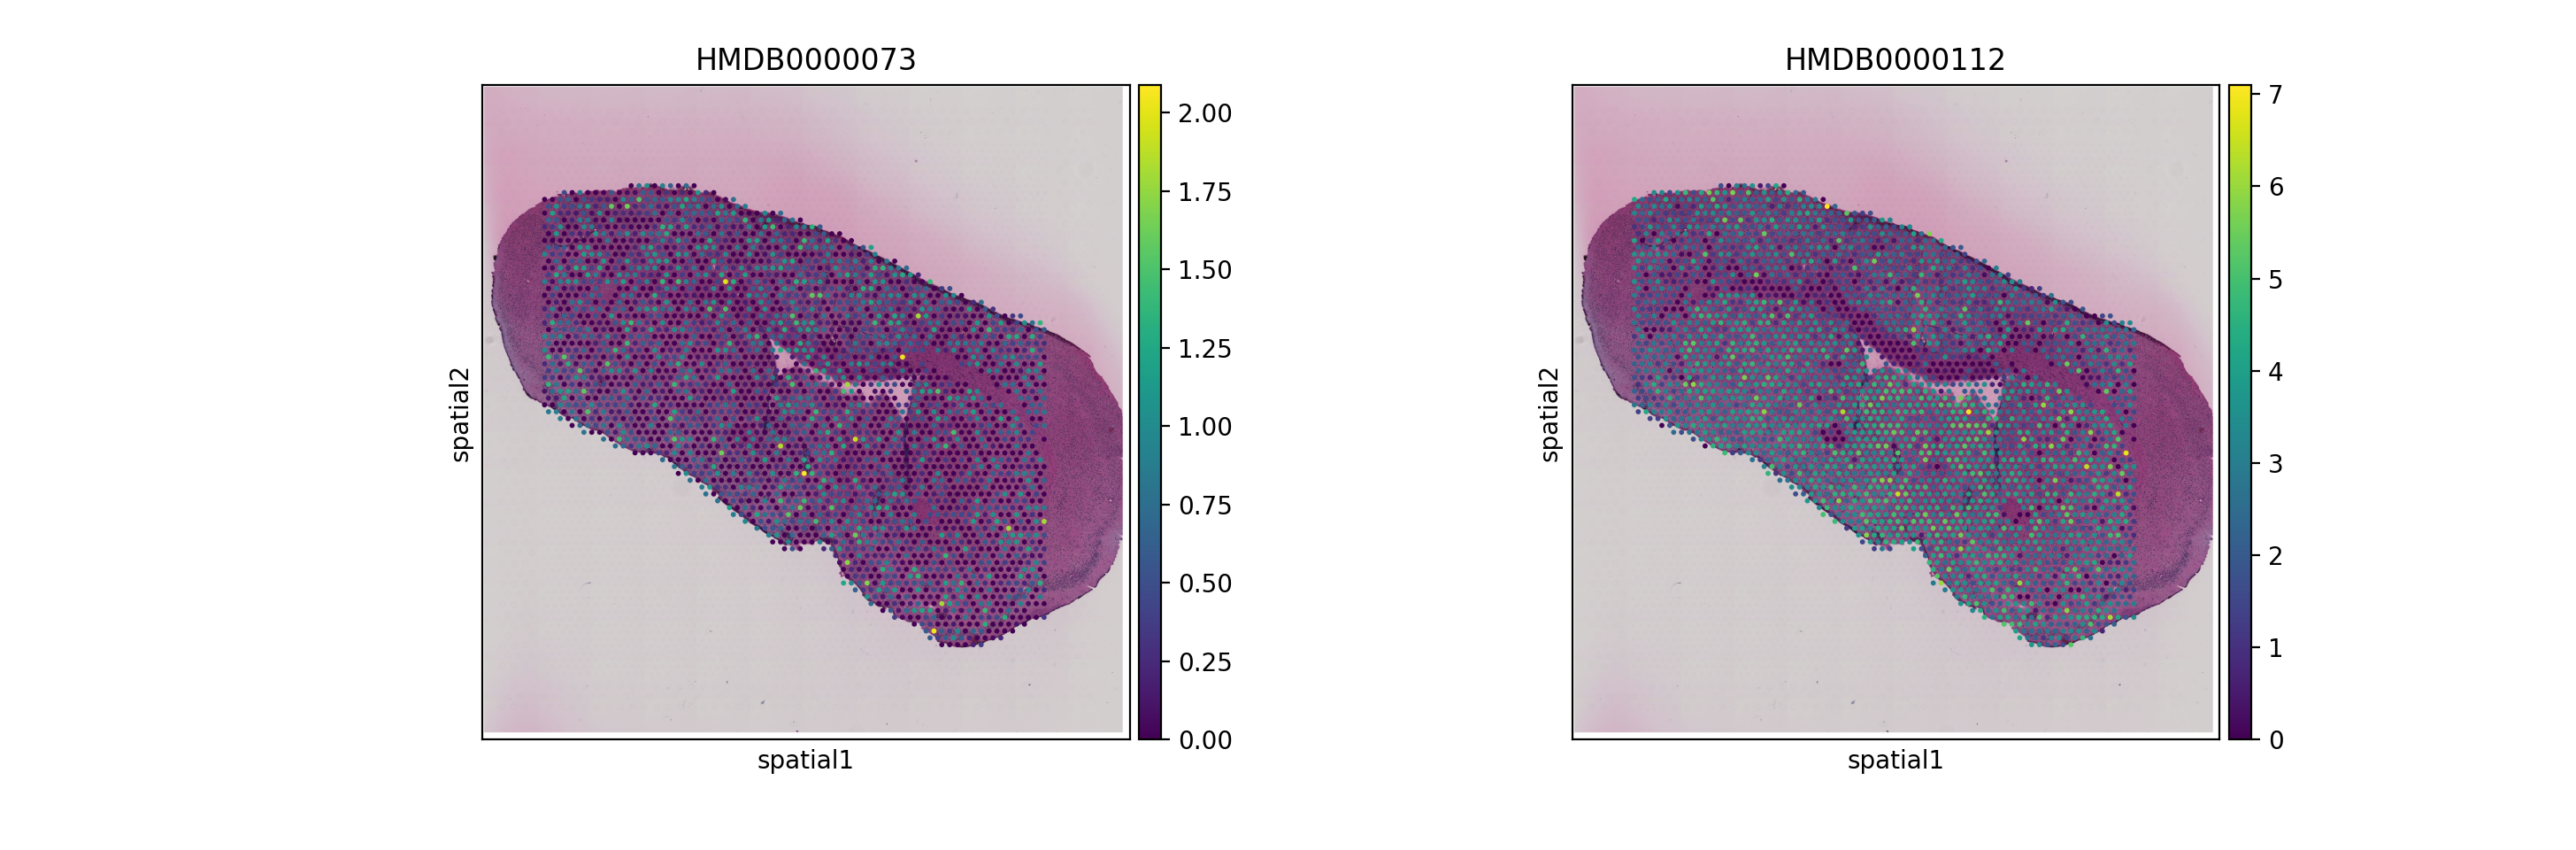

In [41]:
plt.show()

In [33]:
metab = '674.28833' # '551.23688'
misty.uns['interactions'][misty.uns['interactions']['target'] == metab].sort_values("importances", key=abs, ascending=False).head(30)

,target,predictor,view,importances
12416,674.28833,Penk,rna,-19.602921
41544,674.28833,HMDB0000112,meta,14.306241
12657,674.28833,Cacng4,rna,10.688171
41542,674.28833,HMDB0000068,meta,10.186079
41552,674.28833,HMDB0001220,meta,-8.924059
12684,674.28833,Rreb1,rna,-8.574515
12471,674.28833,Tac1,rna,8.378913
12573,674.28833,Scn4b,rna,7.794777
41543,674.28833,HMDB0000073,meta,-7.077589
41541,674.28833,HMDB0000123,meta,6.905298


In [ ]:
# Apply Spatial Smoothing with RNA as reference
w2 = li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", inplace=False, set_diag=False, standardize=False)
rna.layers['smooth'] = w2 @ rna.X

In [ ]:
rna_smooth = rna[:, 'Pdyn'].layers['smooth'].copy()

In [ ]:
sc.AnnData(msi_smooth[:,'Dopamine (double)'].X * rna_smooth.A.flatten())

In [ ]:
import muon as mu

In [ ]:
mdata = mu.MuData({'rna':rna, 'msi':msi_smooth}, obs=rna.obs, uns=rna.uns)

In [ ]:
mdata

In [ ]:
from scipy.sparse import csr_matrix
w3 = np.zeros((mdata.shape[0], mdata.shape[0]))
w3 = csr_matrix(w3)
w3.setdiag(1)
mdata.obsp['spatial_connectivities'] = w3

In [ ]:
mdata

In [ ]:
li.mt.bivar(mdata, function_name='product', x_mod='rna', y_mod='msi', x_layer='smooth', x_use_raw=False, y_use_raw=False, verbose=True, interactions = [('Pdyn', 'Dopamine (double)')])

In [ ]:
mdata.mod['local_scores'].obsm = rna.obsm

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=['Pdyn^Dopamine (double)', 'lesion'])

In [ ]:
plt.show()

In [ ]:
mdata.mod['local_scores'].obs